## Load EST_LIB

In [1]:
import os

In [2]:
from tqdm.notebook import tqdm

In [3]:
from est_lib.util.obspy_util import *
from est_lib.util.obspy_plot import *

# Specify Meta Parameters

In [4]:
file_preamble = "event"
stream_types = ['vel','acc']
channels = {'vel':['HHN','HHE','HHZ'],'acc':['HNN','HNE','HNZ']}
op_dir = os.path.join('..','data')

sta_list = {
    'BFSB','CBB','CLRS','HOLB','HOPB','LLLB','NLLB','NTKA','PACB','PHC','PTRF','SNB','SYMB','VGZ','WOSB'
}

In [5]:
choice = stream_types[0]

## Retrieve Station Metadata

In [6]:
station_metadata = inventory_retriever(sta_list=sta_list)

In [34]:
time = '2019-12-23T20:56:23.555000Z'
mag = '6'
extra = '-clean'
event_folder_name = 'event_{}_{}_{}{}'.format(mag,time.replace(':','_').replace('.','_'),choice,extra)
event_folder_path = os.path.join(op_dir,event_folder_name)

# Create Event Folder if it doesn't Exist
try:
    os.mkdir(event_folder_path)
except FileExistsError:
    print("Folder Already Exists, Moving On!")

In [35]:
# Create Image Folder If it Doesn't Exist
img_folder_path = os.path.join(event_folder_path,'images')
try:
    os.mkdir(img_folder_path)
except FileExistsError:
    print("Folder Already Exists, Moving On!")

# Event Spec

## Retrieve Waveform Data

In [8]:
#data = stream_reader('264_HOLB-velocity.mseed')

data = stream_retriever(event_time=time,time_format='string',
                     seconds_before=600,
                     seconds_after=1500,
                     network='CN',
                     sta_list=sta_list,
                     channel_list=channels[choice],
                     client_obj=client)

## Visualize EQ Source and Stations

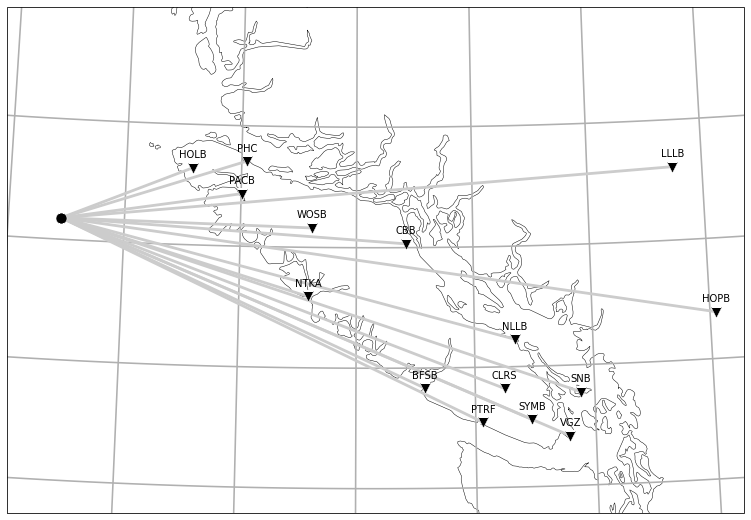

In [9]:
lat = 50.178
lon = -129.816
op = ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    streams=data,
    inventory=station_metadata)
op.savefig(os.path.join(img_folder_path,'event_map'),dpi=op.dpi)

## Visualize Waveforms at Station 'HOLB'

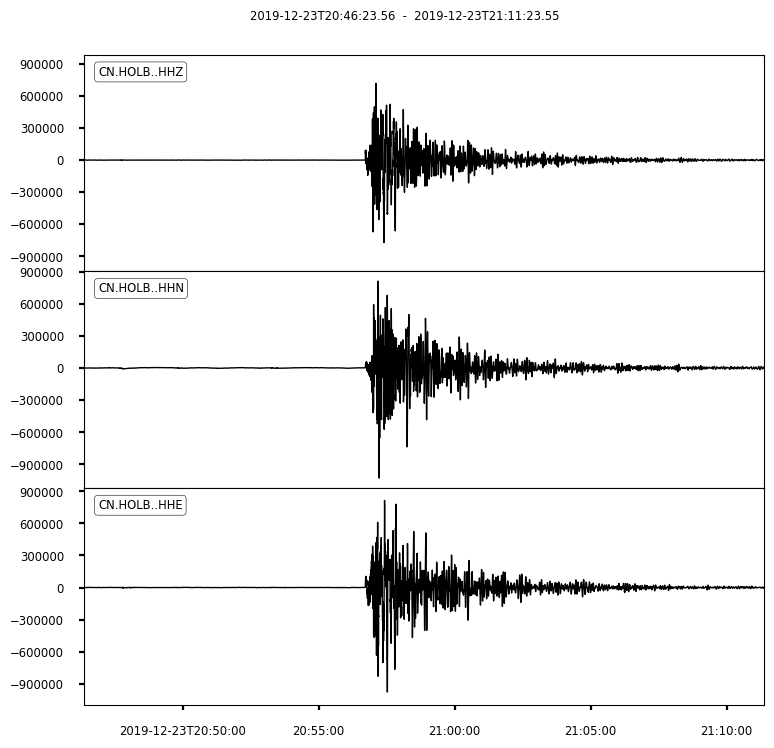

In [10]:
op = data.select(station='HOLB').plot()

In [11]:
working = data.copy()

In [12]:
import obspy

In [13]:
#working.trim(starttime=obspy.UTCDateTime('2019-12-23T20:56'), endtime=obspy.UTCDateTime('2019-12-23T21:15'))

In [14]:
#op = working.plot()

In [15]:
working.filter(type='bandpass', freqmin=3, freqmax=20)

45 Trace(s) in Stream:

CN.BFSB..HHE | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:11:23.550000Z | 100.0 Hz, 150000 samples
...
(43 other traces)
...
CN.WOSB..HHZ | 2019-12-23T20:46:23.560000Z - 2019-12-23T21:11:23.550000Z | 100.0 Hz, 150000 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

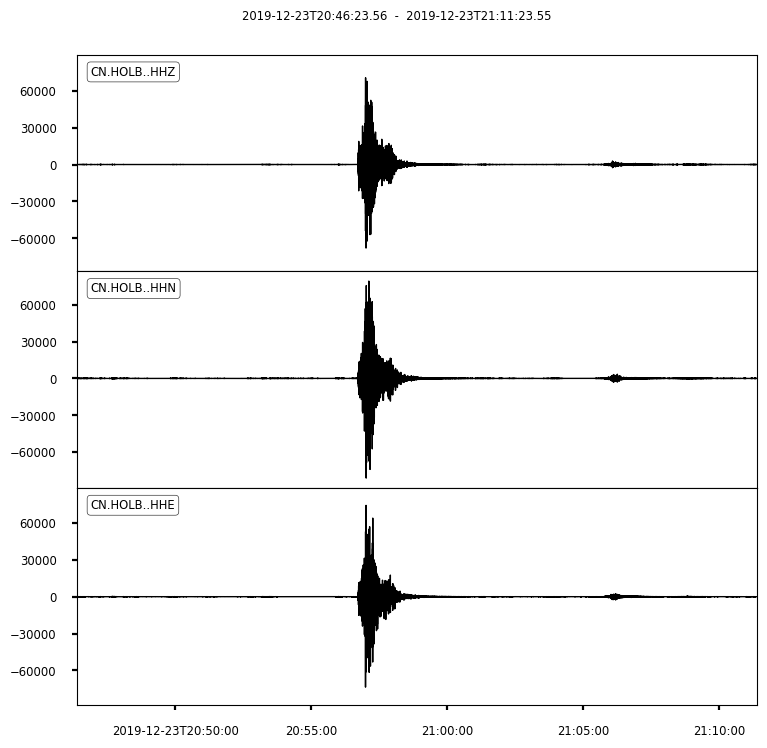

In [16]:
op = working.select(station='HOLB').plot()

In [40]:
# Command List
command_list = list()

# Run Through Sta_list and Cut and Store
for sta in tqdm(sta_list):
    img_path = os.path.join(img_folder_path,'{}.png'.format(sta))
    
    nn_ip_file = '{}.in'.format(sta)
    nn_op_file = '{}.out'.format(sta)
    cha_list = channels[choice]
    
    st_ns = working.select(station=sta,channel=cha_list[0])
    st_ns_fname = os.path.join(event_folder_path,'{}_{}.mseed'.format(sta,cha_list[0]))
    if not st_ns.traces:
        continue
    
    st_ew = working.select(station=sta,channel=cha_list[1])
    st_ew_fname = os.path.join(event_folder_path,'{}_{}.mseed'.format(sta,cha_list[1]))
    if not st_ew.traces:
        continue
    
    st_z = working.select(station=sta,channel=cha_list[2])
    st_z_fname = os.path.join(event_folder_path,'{}_{}.mseed'.format(sta,cha_list[2]))
    if not st_z.traces:
        continue
    
    # Write Streams to Files (writing here to ensure empty stations are ignored outright)
    stream_writer(st_ns,st_ns_fname)
    stream_writer(st_ew,st_ew_fname)
    stream_writer(st_z,st_z_fname)
    
    # InFile String
    in_file_content = '{} {} {}'.format(os.path.relpath(st_ns_fname,'..'),
                                        os.path.relpath(st_ew_fname,'..'),
                                        os.path.relpath(st_z_fname,'..'))
    # Create InFile
    with open(os.path.join(event_folder_path,nn_ip_file),'w') as f:
        f.write(in_file_content)
    command_ip = os.path.relpath(os.path.join(event_folder_path,nn_ip_file),'..')
    
    # Create OutFile
    with open(os.path.join(event_folder_path,nn_op_file),'w') as f:
        f.close()
    command_op = os.path.relpath(os.path.join(event_folder_path,nn_op_file),'..')
    
    cmd = 'python ..\gpd_predict.py -V -C -S {} -I {} -O {}'.format(img_path,command_ip,command_op)
    print(cmd)
    command_list.append(cmd)

  0%|          | 0/15 [00:00<?, ?it/s]

python ..\gpd_predict.py -V -C -S ..\data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\images\HOPB.png -I data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\HOPB.in -O data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\HOPB.out
python ..\gpd_predict.py -V -C -S ..\data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\images\BFSB.png -I data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\BFSB.in -O data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\BFSB.out
python ..\gpd_predict.py -V -C -S ..\data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\images\WOSB.png -I data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\WOSB.in -O data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\WOSB.out
python ..\gpd_predict.py -V -C -S ..\data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\images\NLLB.png -I data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\NLLB.in -O data\event_6_2019-12-23T20_56_23_555000Z_vel-clean\NLLB.out
python ..\gpd_predict.py -V -C -S ..\data\event_6_2019-12-23T20_56_23_555000Z_vel-cl

In [37]:
import subprocess as sp

In [38]:
for command in tqdm(command_list):
    # Multiprocessing Here Potentially
    op = sp.run(command.split(),capture_output=True)
    print(op)

  0%|          | 0/15 [00:00<?, ?it/s]

CompletedProcess(args=['python', '..\\gpd_predict.py', '-V', '-C', '-S', '..\\data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\images', '-I', 'data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\HOPB.in', '-O', 'data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\HOPB.out'], returncode=1, stdout=b'', stderr=b'Traceback (most recent call last):\r\n  File "..\\gpd_predict.py", line 20, in <module>\r\n    import keras\r\nModuleNotFoundError: No module named \'keras\'\r\n')
CompletedProcess(args=['python', '..\\gpd_predict.py', '-V', '-C', '-S', '..\\data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\images', '-I', 'data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\BFSB.in', '-O', 'data\\event_6_2019-12-23T20_56_23_555000Z_vel-clean\\BFSB.out'], returncode=1, stdout=b'', stderr=b'Traceback (most recent call last):\r\n  File "..\\gpd_predict.py", line 20, in <module>\r\n    import keras\r\nModuleNotFoundError: No module named \'keras\'\r\n')
CompletedProcess(args=['python', '..\\